# Statistical analysis

---

In [31]:
import os
import sys
import glob
import logging
import time

import matplotlib.pyplot as plt
import plotly.express as px

import numpy as np
import pandas as pd
from clustergram import Clustergram as CGram
from itertools import combinations

import scipy
from scipy import signal
from scipy import stats

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression as LR

# Data frames combining

In [20]:
# samp_list = ['C0002', 'D0001', 'E0002']
# data_path = os.path.join(''.join(sys.path[0].split('glia')), 'data_glia')

# components_df_list = []
# peaks_df_list = []
# for samp_to_upload in samp_list:
#     samp_upload_path = f'{data_path}/{samp_to_upload}'
#     components_df_list.append(pd.read_csv(f'{samp_upload_path}/components_df.csv'))
#     peaks_df_list.append(pd.read_csv(f'{samp_upload_path}/peaks_properties_df.csv'))
#     print(samp_upload_path)

# total_component_df = pd.concat(components_df_list)
# total_component_df.to_csv(f'{data_path}/total_components_df.csv')

# total_peak_df = pd.concat(peaks_df_list)
# total_peak_df.to_csv(f'{data_path}/total_peaks_properties_df.csv')

/home/wisstock/bio/scripts/microca/data_glia/C0002
/home/wisstock/bio/scripts/microca/data_glia/D0001
/home/wisstock/bio/scripts/microca/data_glia/E0002


# Preprocessing

#### Raw/norm data frames

In [21]:
samp_list = ['C0002', 'D0001', 'E0002']
data_path = os.path.join(''.join(sys.path[0].split('glia')), 'data_glia')

total_component_df = pd.read_csv(f'{data_path}/total_components_df.csv')
print(total_component_df.head())

total_peak_df = pd.read_csv(f'{data_path}/total_peaks_properties_df.csv')
print(total_peak_df.head())

   Unnamed: 0 reg_name  frame_num      time  comp  profile_raw   profile_C  \
0           0    C0002          0  0.000000     0    53.587025 -161.175541   
1           1    C0002          1  1.091983     0    52.102883 -161.175541   
2           2    C0002          2  2.183965     0    51.916756 -161.175541   
3           3    C0002          3  3.275948     0    52.376493 -161.175541   
4           4    C0002          4  4.367931     0    53.452555 -161.175541   

   profile_ddf  
0     0.019450  
1     0.005571  
2    -0.006909  
3     0.023312  
4     0.028068  
   Unnamed: 0.1  Unnamed: 0 sample  comp app_group  peak_i   peak_time  \
0             0           0  C0002     0      ctrl      45   49.139219   
1             1           1  C0002     0      ctrl      98  107.014300   
2             2           2  C0002     0      ctrl     130  141.957745   
3             3           3  C0002     0      ctrl     188  205.292739   
4             4           4  C0002     0      ctrl     229 

In [ ]:

# opti_col = ['sample', 'comp', 'app_group', 'peak_i', 'peak_time', 'rise', 'decay', 'FWHM', 'integral_abs', 'amp_dF']
# opti_df = pf_df.copy()
# opti_df = opti_df[np.intersect1d(opti_df.columns, opti_col)]

# work_df = opti_df
# print(work_df.head())

# Descriptive stat.

#### Pairwise KS-test

In [53]:
stat_param = 'amp_dF'

groups = total_peak_df.app_group.unique()
groups_combinations = list(combinations(groups, 2))

for samp in samp_list:
    samp_df = total_peak_df[total_peak_df['sample'] == samp]
    print(f'Sample {samp}')
    for g_comb in groups_combinations:
        group_1 = samp_df[stat_param][samp_df['app_group'] == g_comb[0]]
        group_2 = samp_df[stat_param][samp_df['app_group'] == g_comb[1]]
        ks_test = stats.ks_2samp(group_1, group_2)
        print(f'KS test for {g_comb} groups')
        print(ks_test)
    print('')

Sample C0002
KS test for ('ctrl', 'C5a') groups
KstestResult(statistic=0.19326923076923078, pvalue=0.3464479313194842, statistic_location=0.8977902853886638, statistic_sign=-1)
KS test for ('ctrl', 'wash') groups
KstestResult(statistic=0.19891304347826086, pvalue=0.23681760904283725, statistic_location=0.8427579475348339, statistic_sign=-1)
KS test for ('C5a', 'wash') groups
KstestResult(statistic=0.09297658862876254, pvalue=0.82574594452871, statistic_location=0.798476752276343, statistic_sign=-1)

Sample D0001
KS test for ('ctrl', 'C5a') groups
KstestResult(statistic=0.1875, pvalue=0.9417746609293252, statistic_location=0.173340118084714, statistic_sign=1)
KS test for ('ctrl', 'wash') groups
KstestResult(statistic=0.3125, pvalue=0.16274797392103071, statistic_location=0.3835046754961183, statistic_sign=1)
KS test for ('C5a', 'wash') groups
KstestResult(statistic=0.4166666666666667, pvalue=0.055654164921702706, statistic_location=0.3695942678638654, statistic_sign=1)

Sample E0002
KS 

#### ECDF and hist plot

In [54]:
# https://towardsdatascience.com/comparing-sample-distributions-with-the-kolmogorov-smirnov-ks-test-a2292ad6fee5
fig = px.ecdf(total_peak_df,
              x=stat_param,
              color='app_group',
              animation_frame='sample')
fig.show()

fig = px.histogram(total_peak_df,
              x=stat_param,
              color='app_group',
              animation_frame='sample',
              marginal='box',
              opacity=0.75)
fig.show()

# Dim. reduction and clasterization

#### Features importance estimation

PCA()


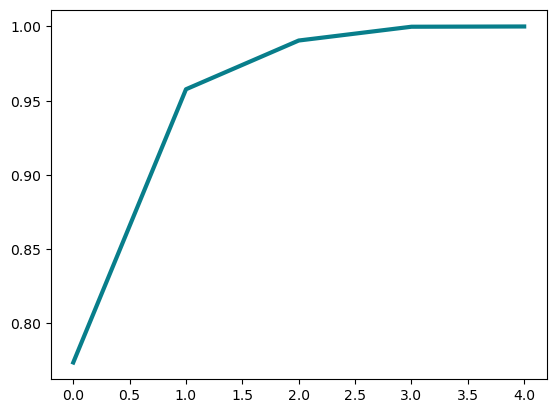

In [9]:
# https://python-bloggers.com/2021/01/3-essential-ways-to-calculate-feature-importance-in-python/
# https://stackoverflow.com/questions/50796024/feature-variable-importance-after-a-pca-analysis

test_features_vals = work_df[['rise', 'decay', 'FWHM', 'integral_dF', 'amp_dF']].values

test_pca = PCA()
test_features_pca = test_pca.fit(X=test_features_vals)

print(test_features_pca)

plt.plot(test_features_pca.explained_variance_ratio_.cumsum(), lw=3, color='#087E8B')
plt.show()


## PCA

#### Features estimation

NameError: name 'y' is not defined

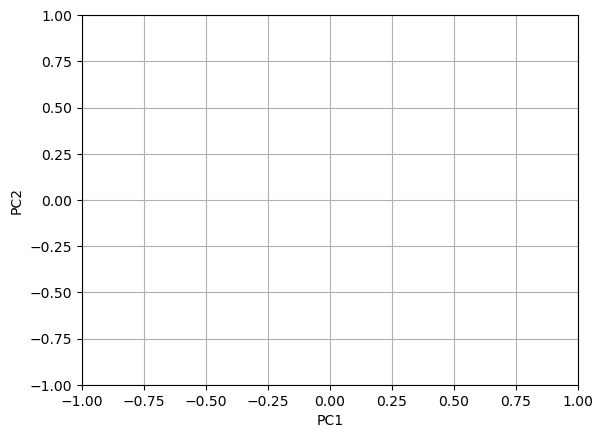

In [12]:
# https://stackoverflow.com/questions/50796024/feature-variable-importance-after-a-pca-analysis

def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = y)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')


features = work_df[['rise', 'decay', 'FWHM', 'integral_dF', 'amp_dF']].values
pca = PCA()
principal = pca.fit_transform(features)

plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()
myplot(principal[:,0:2], np.transpose(pca.components_[0:2, :]))
plt.show()

#### PCA calc

In [13]:
def PCA_calc(features_vals, factor_df, n=2):
    tic = time.perf_counter()

    if n == 2:
        ax_list = ['x', 'y']
    elif n == 3:
        ax_list = ['x', 'y', 'z']
    else:
        logging.fatal('Incorrect dimension number!')

    pca = PCA(n_components=n)
    principal_res = pca.fit_transform(features_vals)
    df_principal = pd.DataFrame(data = principal_res,
                                columns = ax_list)
    df_principal = pd.concat([factor_df, df_principal], axis = 1)

    toc = time.perf_counter()
    logging.info(f'PCA calc in {toc - tic:0.4f} seconds')
    return df_principal

n_components = 3
features_vals = work_df[['rise', 'decay', 'FWHM', 'integral_dF', 'amp_dF']].values
factor_df = work_df[['sample', 'comp', 'app_group', 'peak_i', 'peak_time', ]]

pca_df = PCA_calc(features_vals=features_vals, factor_df=factor_df, n=n_components)

#### PCA plot

In [14]:
group_factor = 'app_group'

if n_components == 2:
    fig = px.scatter(pca_df,
                     x='x', y='y',
                     color=group_factor,
                     symbol=group_factor)
    dot_size = 6
elif n_components == 3:
    fig = px.scatter_3d(pca_df,
                        x='x', y='y', z='z',
                        color=group_factor,
                        symbol=group_factor)
    dot_size = 2
else:
    logging.fatal('Incorrect n')

fig.update_traces(marker=dict(size=8,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),
                  legend= {'itemsizing': 'constant'},
                  scene=dict(xaxis=dict(showaxeslabels=False, showticklabels=False, showbackground=False, title=''),
                             yaxis=dict(showaxeslabels=False, showticklabels=False, showbackground=False, title=''), 
                             zaxis=dict(showaxeslabels=False, showticklabels=False, showbackground=False, title='')))
fig.show()

## LDA

#### LDA calc

In [9]:
def LDA_calc(features_vals, factor_df, group_column=None):
    tic = time.perf_counter()

    group_vals = factor_df.loc[:,group_column].values

    lda = LDA()
    lda_fit = lda.fit_transform(X=features_vals, y=group_vals)
    df_lda = pd.DataFrame({'lda1':lda_fit[:,0], 'lda2':lda_fit[:,1]})
    df_lda = pd.concat([factor_df, df_lda], axis = 1)

    toc = time.perf_counter()
    logging.info(f'PCA calc in {toc - tic:0.4f} seconds')
    return df_lda

features_vals = work_df[['rise', 'decay', 'FWHM', 'integral_abs', 'amp_dF']].values
factor_df = work_df[['sample', 'comp', 'app_group', 'peak_i', 'peak_time', ]]
lda_df = LDA_calc(features_vals=features_vals, factor_df=factor_df, group_column='app_group')


print(lda_df.head())

# plotting
# fig = px.box(lda_df, x="app_group", y="lda", color='app_group', points='all')
fig = px.scatter(lda_df, x="lda1", y="lda2", color='app_group', symbol='app_group', width=700, height=500)

fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig.show()

   sample  comp app_group  peak_i    peak_time      lda1      lda2
0  E_0002     3      wash     688   749.961308  0.602024 -1.038953
1  E_0002     3      wash     723   788.113409  0.613745 -0.446181
2  E_0002     3      wash     823   897.119413  0.707306 -0.795054
3  E_0002     3      wash    1005  1095.510340 -0.370352 -0.261143
4  E_0002     3      wash    1068  1164.184123  0.183650 -0.549052


## Clustergram

In [10]:
cgram = CGram(range(1, 5), n_init=1000)

cgram.fit(work_df[['rise', 'decay', 'FWHM', 'integral_abs', 'amp_dF']])

K=1 skipped. Mean computed from data directly.
K=2 fitted in 1.3814373016357422 seconds.
K=3 fitted in 1.0136895179748535 seconds.
K=4 fitted in 1.164806842803955 seconds.


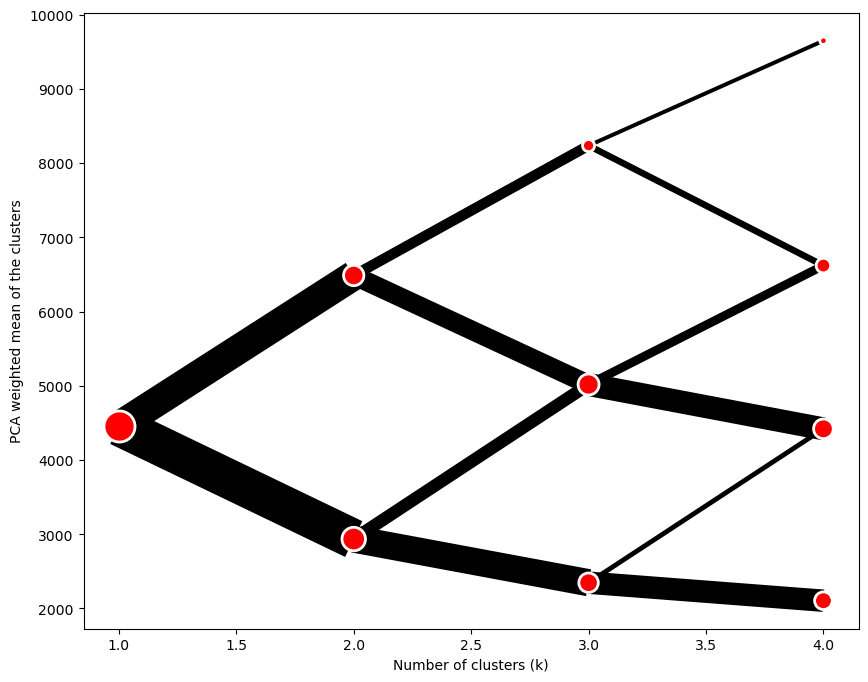

In [11]:
ax = cgram.plot(figsize=(10, 8))
ax.yaxis.grid(False)